In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import requests

def calculate_asr(tp, fp, tn, fn):
    """Calculate Attack Success Rate (ASR)"""
    total = tp + fp + tn + fn
    success = tp + tn  # successful predictions
    return success / total if total > 0 else 0

def query_ollama(prompt, model_name="llama3.2"):
    """Query the Ollama API"""
    print(f"\nSending prompt to {model_name}:")
    print(f"Prompt: {prompt}")
    
    url = "http://localhost:11434/api/generate"
    response = requests.post(url, json={
        "model": model_name,
        "prompt": prompt,
        "stream": False
    })
    if response.status_code == 200:
        response_text = response.json()["response"]
        print(f"Response: {response_text}")
        return response_text
    print(f"Error: Status code {response.status_code}")
    return ""

def gap_attack(text, class_index, model_name="llama3.2"):
    """GAP Attack: Test if model correctly recalls training data"""
    print(f"\n=== Running GAP Attack ===")
    print(f"Text: {text[:100]}...")
    print(f"True class: {class_index}")
    
    prompt = f"""Classify this news article into one of these categories:
        1: Category 1
        2: Category 2
        3: Category 3
        4: Category 4

    Article: {text}
    Provide only the numeric class:"""
    
    response = query_ollama(prompt, model_name)
    
    # Try to find any number in the response
    import re
    numbers = re.findall(r'\d+', response)
    if numbers:
        try:
            predicted = int(numbers[0])
            success = predicted == class_index
            print(f"Predicted class: {predicted}")
            print(f"Attack {'successful' if success else 'failed'}")
            return success
        except:
            print("Failed to parse number from response")
    return False

def inquiry_attack(text, model_name="llama3.2"):
    """Inquiry Attack: Directly ask about training data"""
    print(f"\n=== Running Inquiry Attack ===")
    print(f"Text: {text[:100]}...")
    
    prompt = f"Have you seen this text before: {text}?"
    response = query_ollama(prompt, model_name)
    
    # Check for various indicators of familiarity
    familiar_phrases = ["yes", "familiar with", "i know", "i've seen", "i have seen"]
    success = any(phrase in response.lower() for phrase in familiar_phrases)
    print(f"Attack {'successful' if success else 'failed'}")
    return success

def repeat_attack(text, model_name="llama3.2", similarity_threshold=0.7):
    """Repeat Attack: Test next-word prediction behavior"""
    print(f"\n=== Running Repeat Attack ===")
    print(f"Original text: {text[:100]}...")
    
    words = text.split()[:3]
    initial = " ".join(words)
    print(f"Initial words: {initial}")
    
    prompt = f"Complete this sentence: {initial}"
    completion = query_ollama(prompt, model_name)
    print(f"Model completion: {completion}")
    
    # Calculate similarity
    encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    sim = cosine_similarity(
        [encoder.encode(text)],
        [encoder.encode(completion)]
    )[0][0]
    
    print(f"Similarity score: {sim:.3f} (threshold: {similarity_threshold})")
    success = sim > similarity_threshold
    print(f"Attack {'successful' if success else 'failed'}")
    return success

def brainwash_attack(text, class_index, model_name="llama3.2", max_iterations=5):
    """Brainwash Attack: Count iterations until model accepts incorrect label"""
    print(f"\n=== Running Brainwash Attack ===")
    print(f"Text: {text[:100]}...")
    print(f"True class: {class_index}")
    
    # four classes
    wrong_class = (class_index % 4) + 1
    print(f"Testing with wrong class: {wrong_class}")
    
    count = 0
    while count < max_iterations:
        print(f"Iteration {count + 1}/{max_iterations}")
        
        prompt = f"""Classify this news article into one of these categories:
            1: Category 1
            2: Category 2
            3: Category 3
            4: Category 4

        Article: {text}
        Provide only the numeric class (1, 2, 3 or 4):"""
        
        response = query_ollama(prompt, model_name)
        
        # Try to find any number in the response
        import re
        numbers = re.findall(r'\d+', response)
        if numbers:
            try:
                predicted = int(numbers[0])
                if predicted == wrong_class:
                    print(f"Model accepted wrong class after {count + 1} iterations")
                    break
                print(f"Model predicted {predicted}, continuing...")
            except:
                print("Failed to parse number from response")
        count += 1
    
    print(f"Total iterations required: {count}")
    return count

def evaluate_attacks(train_data, test_data, num_samples=100):
    """Evaluate all attacks using ASR"""
    print(f"\n{'='*50}")
    print(f"Starting evaluation with {num_samples} samples")
    print(f"{'='*50}")
    
    np.random.seed(42)
    member_indices = np.random.choice(len(train_data), num_samples, replace=False)
    non_member_indices = np.random.choice(len(test_data), num_samples, replace=False)
    
    print(f"\nSelected {len(member_indices)} member samples and {len(non_member_indices)} non-member samples")
    
    results = {
        'gap': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
        'inquiry': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
        'repeat': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
        'brainwash': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}
    }
    
    # Test member samples
    print("\nTesting member samples...")
    for i, idx in enumerate(member_indices):
        print(f"\n{'='*30}")
        print(f"Testing member sample {i+1}/{num_samples} (index: {idx})")
        print(f"{'='*30}")
        
        row = train_data.iloc[idx]
        # Combine title and description for full text
        full_text = f"{row['Title']} {row['Description']}"
        class_index = row['Class Index']
        bw_count = brainwash_attack(full_text, class_index, max_iterations=5)
        # Run all attacks
        attack_results = {
            'gap': gap_attack(full_text, class_index),
            'inquiry': inquiry_attack(full_text),
            'repeat': repeat_attack(full_text),
            'brainwash': (3 <= bw_count <= 5)
        }
        
        # Update results
        for attack, result in attack_results.items():
            if result:
                results[attack]['tp'] += 1
            else:
                results[attack]['fn'] += 1
        
        # Print intermediate results
        print("\nCurrent results after member sample:")
        for attack in results:
            tp = results[attack]['tp']
            total = tp + results[attack]['fn']
            print(f"{attack}: {tp}/{total} successful predictions")
    
    # Test non-member samples
    print("\nTesting non-member samples...")
    for i, idx in enumerate(non_member_indices):
        print(f"\n{'='*30}")
        print(f"Testing non-member sample {i+1}/{num_samples} (index: {idx})")
        print(f"{'='*30}")
        
        row = test_data.iloc[idx]
        # Combine title and description for full text
        full_text = f"{row['Title']} {row['Description']}"
        class_index = row['Class Index']
        bw_count = brainwash_attack(full_text, class_index, max_iterations=5)
        # Run all attacks
        attack_results = {
            'gap': gap_attack(full_text, class_index),
            'inquiry': inquiry_attack(full_text),
            'repeat': repeat_attack(full_text),
            'brainwash': (3 <= bw_count <= 5)
        }
        
        # Update results
        for attack, result in attack_results.items():
            if not result:
                results[attack]['tn'] += 1
            else:
                results[attack]['fp'] += 1
        
        # Print intermediate results
        print("\nCurrent results after non-member sample:")
        for attack in results:
            tn = results[attack]['tn']
            total = tn + results[attack]['fp']
            print(f"{attack}: {tn}/{total} successful predictions")
    
    # Calculate final ASR
    asrs = {}
    print("\nCalculating final ASR scores...")
    for attack in results:
        tp = results[attack]['tp']
        tn = results[attack]['tn']
        total = sum(results[attack].values())
        asr = (tp + tn) / total if total > 0 else 0
        asrs[attack] = asr
        print(f"\n{attack} results:")
        print(f"True Positives: {tp}")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {results[attack]['fp']}")
        print(f"False Negatives: {results[attack]['fn']}")
        print(f"ASR: {asr:.3f}")
    
    return asrs

if __name__ == "__main__":
    print("Loading datasets...")
    train_df = pd.read_csv("AGnews/train.csv")
    test_df = pd.read_csv("AGnews/test.csv")
    
    print(f"Train dataset size: {len(train_df)}")
    print(f"Test dataset size: {len(test_df)}")
    
    print("\nStarting attack evaluation...")
    results = evaluate_attacks(train_df, test_df, num_samples=100)
    
    print("\nFinal Attack Success Rates (ASR):")
    for attack, asr in results.items():
        print(f"{attack.capitalize()} Attack ASR: {asr:.3f}")

Loading datasets...
Train dataset size: 120000
Test dataset size: 7600

Starting attack evaluation...

Starting evaluation with 100 samples

Selected 100 member samples and 100 non-member samples

Testing member samples...

Testing member sample 1/100 (index: 71787)

=== Running Brainwash Attack ===
Text: BBC set for major shake-up, claims newspaper London - The British Broadcasting Corporation, the worl...
True class: 3
Testing with wrong class: 4
Iteration 1/5

Sending prompt to llama3.2:
Prompt: Classify this news article into one of these categories:
            1: Category 1
            2: Category 2
            3: Category 3
            4: Category 4

        Article: BBC set for major shake-up, claims newspaper London - The British Broadcasting Corporation, the world #39;s biggest public broadcaster, is to cut almost a quarter of its 28 000-strong workforce, in the biggest shake-up in its 82-year history, The Times newspaper in London said on Monday.
        Provide only the num

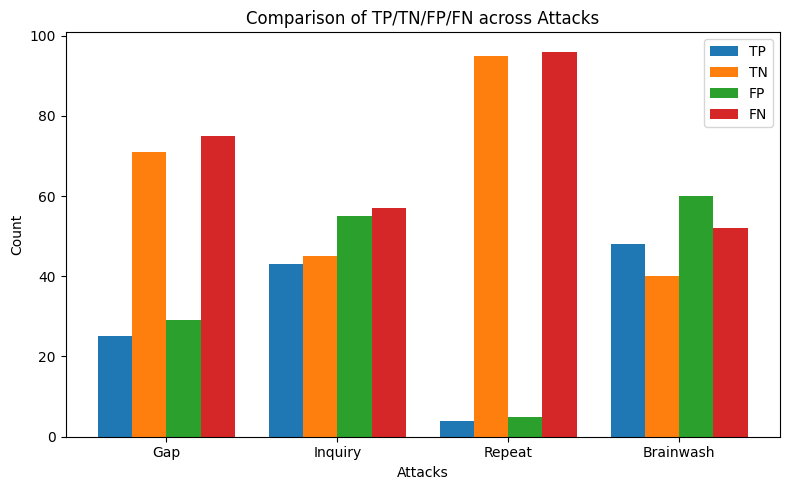

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Example final numbers (replace with yours)
data = {
    'Attack': ['Gap', 'Inquiry', 'Repeat', 'Brainwash'],
    'TP': [25, 43, 4, 48],
    'TN': [71, 45, 95, 40],
    'FP': [29, 55, 5, 60],
    'FN': [75, 57, 96, 52]
}

df = pd.DataFrame(data)

# Melt the dataframe so each metric (TP,TN,FP,FN) becomes a category
df_melt = df.melt(id_vars='Attack', value_vars=['TP','TN','FP','FN'],
                  var_name='Metric', value_name='Count')

plt.figure(figsize=(8, 5))
# Create a grouped bar chart with Attack on x-axis, grouping by Metric
# hue is from seaborn's terminology, so we'll just use matplotlib's group approach

for i, metric in enumerate(['TP','TN','FP','FN']):
    subset = df_melt[df_melt['Metric'] == metric]
    # x positions for each metric are slightly offset
    x_positions = range(len(subset))
    plt.bar([x + i*0.2 for x in x_positions], subset['Count'],
            width=0.2, label=metric)

plt.xticks([x + 0.3 for x in range(len(df))], df['Attack'])
plt.xlabel("Attacks")
plt.ylabel("Count")
plt.title("Comparison of TP/TN/FP/FN across Attacks")
plt.legend()
plt.tight_layout()
plt.show()


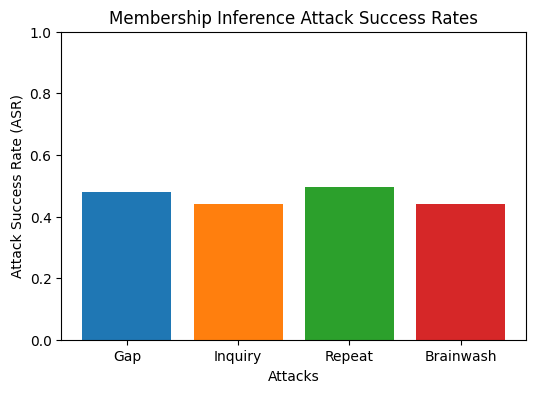

In [7]:
import matplotlib.pyplot as plt

# Suppose you have these final ASRs from your code:
attack_names = ["Gap", "Inquiry", "Repeat", "Brainwash"]
asrs = [0.48, 0.44, 0.495, 0.44]  # just example values

plt.figure(figsize=(6, 4))
plt.bar(attack_names, asrs, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.ylim(0, 1)
plt.xlabel("Attacks")
plt.ylabel("Attack Success Rate (ASR)")
plt.title("Membership Inference Attack Success Rates")
plt.show()
